In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#From sunspots example...

In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 102kB 6.8MB/s 


In [3]:
import tensorflow as tf
import kerastuner as kt
print(tf.__version__)

2.5.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-06-19 18:47:10--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.008s  

2021-06-19 18:47:11 (8.59 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



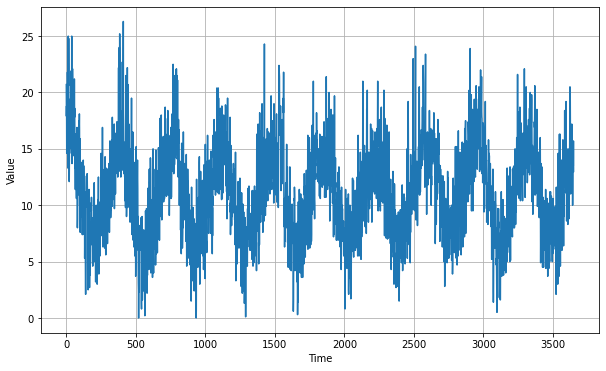

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = np.array(time_step[:split_time])
x_train = np.array(temps[:split_time])
time_valid = np.array(time_step[split_time:])
x_valid = np.array(temps[split_time:])

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(valid_set)
print(x_valid.shape)

def create_model(hp):
  
  hp_conv_filter = hp.Int('hp_conv_filter', min_value=32, max_value=256)
  hp_gru_1_units = hp.Int('hp_gru_1_units', min_value=32, max_value=128)
  hp_gru_2_units = hp.Int('hp_gru_2_units', min_value=32, max_value=128)
  hp_dense_1_units = hp.Int('hp_dense_1_units', min_value=30, max_value=80)
  hp_dense_2_units = hp.Int('hp_dense_2_units', min_value=30, max_value=80)

  
  model = tf.keras.models.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Conv1D(filters=hp_conv_filter, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hp_gru_1_units, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(hp_gru_2_units, return_sequences=True)),
    tf.keras.layers.Dense(hp_dense_1_units, activation="relu"),
    tf.keras.layers.Dense(hp_dense_2_units, activation="relu"),
    tf.keras.layers.Dense(1),
  ])

    # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                metrics=["mae"])
  
  return model



<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1150,)


In [11]:
tuner = kt.Hyperband(create_model,
                     objective='val_mae',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_set, epochs=50, validation_data=valid_set, callbacks=[stop_early])

In [14]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.get('learning_rate')

In [ ]:
model = tf.keras.models.Sequential([
  # YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=best_hps.get('hp_conv_filter'), kernel_size=5,
                    strides=1, padding="causal",
                    activation="relu",
                    input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(best_hps.get('hp_gru_1_units'), return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(best_hps.get('hp_gru_2_units'), return_sequences=True)),
  tf.keras.layers.Dense(best_hps.get('hp_dense_1_units'), activation="relu"),
  tf.keras.layers.Dense(best_hps.get('hp_dense_2_units'), activation="relu"),
  tf.keras.layers.Dense(1),
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
              metrics=["mae"])
  
model.fit(train_set, epochs=50, validation_data=valid_set, callbacks=[stop_early])

In [25]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

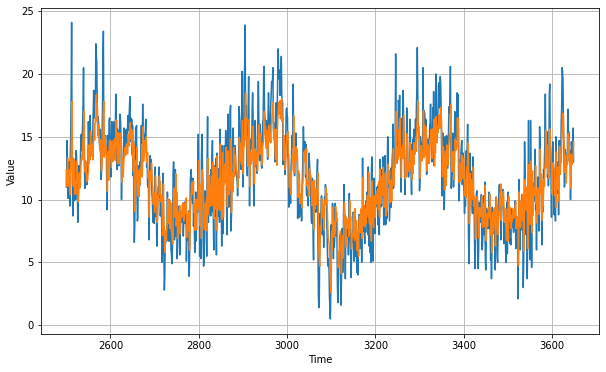

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8597279

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.75298  11.201638 12.437923 ... 13.488287 13.541211 14.684597]
